In [1]:
import torch
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = ['.'] + sorted(set(''.join(words)))
stoi = {s:i for i, s in enumerate(chars)}
itos = chars
print(chars)
vocab_size = len(chars)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
from collections import deque

In [7]:
block_size = 8

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)
        context = deque([0] * block_size)
        for ch in w + '.':
            ix = stoi[ch]
            X.append(list(context))
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context.popleft()
            context.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

g = torch.Generator().manual_seed(2147483647)
train_words, dev_words, test_words = torch.utils.data.random_split(words, [0.8, 0.1, 0.1], generator=g)

In [8]:
len(train_words), len(dev_words), len(test_words)

(25627, 3203, 3203)

In [9]:
Xtr, Ytr = build_dataset(train_words)
Xdev, Ydev = build_dataset(dev_words)
Xtest, Ytest = build_dataset(test_words)

In [10]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if x.ndim == 2:
            dim = (0, )
        elif x.ndim == 3:
            dim = (0, 1)
        else:
            raise RuntimeError("x.dim should be 2 or 3")
        if self.training:
            xmean = x.mean(dim, keepdim=False)
            xvar = x.var(dim, keepdim=False)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.runnign_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        flatten = x.view(B, T//self.n, C*self.n)
        if flatten.shape[1] == 1:
            flatten = flatten.squeeze(1)
            # 10, 1, 3 -> 10, 3
        self.out = flatten
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [22]:
torch.manual_seed(42)

In [23]:
n_embed = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embed),
->    FlattenConsecutive(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
->    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Make last layer less confident. But Why?

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
    
#    [ ([1], [2])   ([3], [4]) ([5], [6]) ([7], [8]) ] K, 4, X
# -> [((|hidden1|) (|hidden2|)) (|hidden3|) (|hidden4|)] K, 2, X
# ->        (|hidden'1|)             (|hidden'2|), K, 1, X -> K, X
# ->                   (|hidden''1|)

76579


In [24]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 16],
        [ 0,  0,  0,  0, 14,  1,  4,  9],
        [ 0,  0,  0,  0,  0,  0, 11,  1],
        [ 0,  0,  1, 20,  8,  1, 18, 22]])

In [25]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [26]:
model.layers[3].running_mean.shape

torch.Size([128])

In [27]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None  # Warn! typo like `p.gard` doesn't raise an error!!
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # trace stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3099
  10000/ 200000: 2.3670
  20000/ 200000: 1.8938
  30000/ 200000: 1.6615
  40000/ 200000: 2.0274
  50000/ 200000: 2.0713
  60000/ 200000: 1.8292
  70000/ 200000: 1.8478
  80000/ 200000: 1.9271
  90000/ 200000: 1.9339
 100000/ 200000: 1.9517
 110000/ 200000: 1.9659
 120000/ 200000: 1.6422
 130000/ 200000: 2.1457
 140000/ 200000: 2.0845
 150000/ 200000: 2.0422
 160000/ 200000: 1.6222
 170000/ 200000: 1.6528
 180000/ 200000: 1.8198
 190000/ 200000: 1.8619


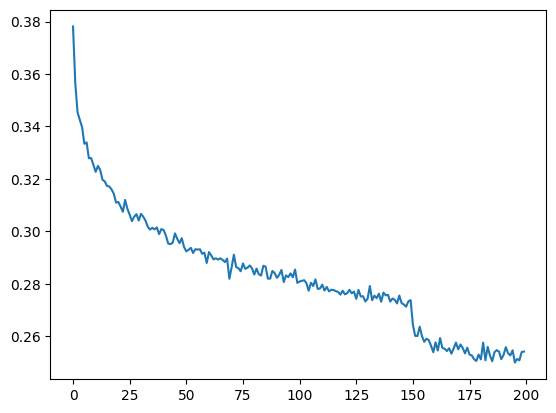

In [29]:
loss_meani = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(loss_meani)

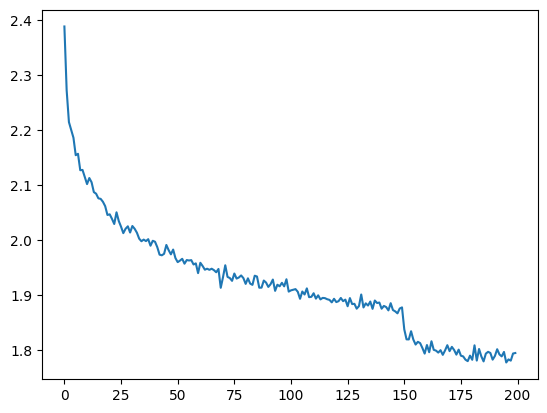

In [30]:
plt.plot(10**loss_meani)

In [31]:
for layer in model.layers:
    layer.training = False

In [32]:
@torch.no_grad()
def evaluate_loss(data):
    Xs, Ys = data
    logits = model(Xs)
    loss = F.cross_entropy(logits, Ys)
    return loss.item()

In [33]:
print(f'train: {evaluate_loss((Xtr, Ytr))}')
print(f'dev(val): {evaluate_loss((Xdev, Ydev))}')

train: 2.194939374923706
dev(val): 2.4818785190582275


## perf log
- original (3 chars context + 200 hidden neurons, 12K params): train 2.27, val: 2.35
- context 3 -> 8 (22K params): train: 2.24, val: 2.39
- flat -> hierachical (22K params): train: 2.42, val: 2.53

In [20]:
g = torch.Generator().manual_seed(12345)

for _ in range(20):
    out = []
    context = deque([0] * block_size)
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context.popleft()
        context.append(ix)
        
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

suraftat.
taten.
jozzelyn.
jennatdegus.
teyashawue.
brendley.
zhayla.
shbusa.
devitt.
fled.
gdom.
zepphepd.
zhander.
jazzabella.
jozabeth.
shawn.
odalynn.
khalsoch.
callowa.
johny.
